<a href="https://colab.research.google.com/github/akashgardas/Machine-Learning/blob/clustering/DBSCAN/DBSCAN_NYC_Taxi_Trip_Duration_Prediction_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYC Taxi Trip Duration Prediction using DBSCAN
- Datasource: https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data


## Scenario

A **ride-sharing company** operates thousands of taxi rides every day in New York City.

**Problems they face:**

- Pickup locations are **not categorized**
- Some areas are **very crowded**, some are **rarely used**
- GPS data contains **noise** (random, one-time pickups)
- Demand hotspots change dynamically

**The company wants to:**

- Discover **natural pickup hotspots**
- Ignore **random or rare pickup points**
- Understand **high-density demand zones**
- Improve:
    - Driver allocation
    - Surge pricing
    - Route planning

They hire you as a **Data Scientist** to analyze pickup locations and identify **natural demand clusters**, **without knowing how many hotspots exist**.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

## Load & Inspect Data

In [ ]:
path = '/content/drive/MyDrive/Tek works/ML Data Source/Kaggle/UnsupervisedLearning_Data/NewYorkCityTaxiTripDuration.csv'
df = pd.read_csv(path)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
df.shape

(1458644, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [ ]:
df_sample = df.sample(100000)
df_sample.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
119647,id2709020,1,2016-04-25 16:55:03,2016-04-25 16:57:12,1,-73.991287,40.765175,-73.982536,40.777283,N,129
503601,id3062161,1,2016-04-27 06:36:17,2016-04-27 06:45:31,2,-73.994652,40.750465,-73.975372,40.763088,N,554
440669,id2437714,1,2016-03-04 16:46:11,2016-03-04 16:54:43,1,-73.949783,40.796112,-73.970772,40.788433,N,512
1412369,id3453047,2,2016-03-20 04:16:07,2016-03-20 04:35:43,1,-73.987144,40.749054,-73.955254,40.716133,N,1176
981925,id0712409,2,2016-03-18 14:08:43,2016-03-18 14:37:14,5,-73.995918,40.769230,-73.961250,40.758579,N,1711


In [ ]:
df_sample.reset_index(drop=True, inplace=True)
df_sample.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2709020,1,2016-04-25 16:55:03,2016-04-25 16:57:12,1,-73.991287,40.765175,-73.982536,40.777283,N,129
1,id3062161,1,2016-04-27 06:36:17,2016-04-27 06:45:31,2,-73.994652,40.750465,-73.975372,40.763088,N,554
2,id2437714,1,2016-03-04 16:46:11,2016-03-04 16:54:43,1,-73.949783,40.796112,-73.970772,40.788433,N,512
3,id3453047,2,2016-03-20 04:16:07,2016-03-20 04:35:43,1,-73.987144,40.749054,-73.955254,40.716133,N,1176
4,id0712409,2,2016-03-18 14:08:43,2016-03-18 14:37:14,5,-73.995918,40.769230,-73.961250,40.758579,N,1711


## Select Features

In [ ]:
# pickup_longitude, and pickup_latitude
X = df_sample[['pickup_longitude', 'pickup_latitude']]
X.head()

,pickup_longitude,pickup_latitude
0,-73.991287,40.765175
1,-73.994652,40.750465
2,-73.949783,40.796112
3,-73.987144,40.749054
4,-73.995918,40.769230


## Data Preprocessing

In [ ]:
# Scale the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Experimentation

### DBSCAN - Experiment 1

In [ ]:
dbscan1 = DBSCAN(eps=0.1, min_samples=5)
labels1 = dbscan1.fit_predict(X_scaled)

### DBSCAN - Experiment 2

In [ ]:
dbscan2 = DBSCAN(eps=0.2, min_samples=5)
labels2 = dbscan2.fit_predict(X_scaled)

### DBSCAN - Experiment 3

In [ ]:
dbscan3 = DBSCAN(eps=0.3, min_samples=5)
labels3 = dbscan3.fit_predict(X_scaled)

## Evaluate Clusters

In [ ]:
def evaluate_clusters(labels):
    n_clusters = len(set(labels))
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique_labels, counts))
    print(f'Number of clusters: {n_clusters}')

    n_noise = np.sum(labels == -1)
    print(f'Number of noise points: {n_noise}')
    print(f'Percentage of noise points: {n_noise / len(labels) * 100:.2f}%')

In [ ]:
evaluate_clusters(labels1)

Number of clusters: 36
Number of noise points: 385
Percentage of noise points: 0.39%


In [ ]:
evaluate_clusters(labels2)

Number of clusters: 11
Number of noise points: 180
Percentage of noise points: 0.18%


In [ ]:
evaluate_clusters(labels3)

Number of clusters: 8
Number of noise points: 114
Percentage of noise points: 0.11%


### Silhouette Scores

In [ ]:
# score for dbscan1
from sklearn.metrics import silhouette_score
silhouette_score(X_scaled, labels1)

np.float64(0.19733579932856762)

In [ ]:
silhouette_score(X_scaled, labels2)

np.float64(0.5606645961705465)

In [ ]:
silhouette_score(X_scaled, labels3)

np.float64(0.11564258523297773)

## Visualization

In [ ]:
X

,pickup_longitude,pickup_latitude
0,-73.991287,40.765175
1,-73.994652,40.750465
2,-73.949783,40.796112
3,-73.987144,40.749054
4,-73.995918,40.769230
...,...,...
99995,-73.955742,40.779400
99996,-73.982674,40.767220
99997,-73.870911,40.773773
99998,-73.991814,40.756863


In [ ]:
X = X.values

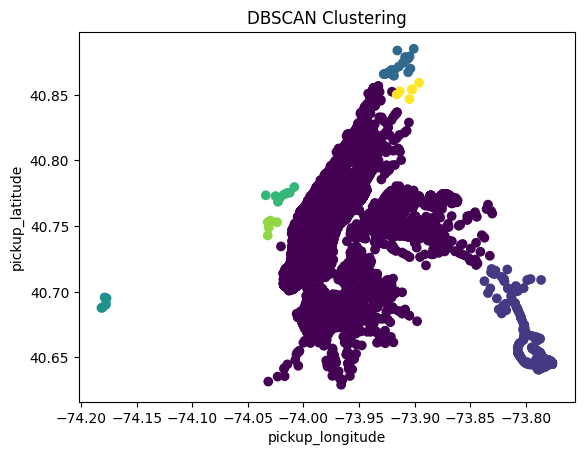

In [ ]:
mask_clusters = labels3 != -1
plt.scatter(x=X[mask_clusters, 0], y=X[mask_clusters, 1], c=labels3[mask_clusters], cmap='viridis')
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.title('DBSCAN Clustering')
plt.show()

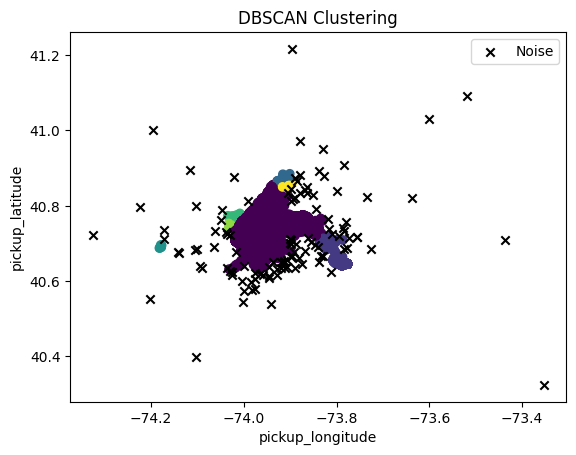

In [ ]:
mask_clusters = labels3 != -1
mask_noise = labels3 == -1

plt.scatter(x=X[mask_clusters, 0], y=X[mask_clusters, 1], c=labels3[mask_clusters], cmap='viridis')
plt.scatter(x=X[mask_noise, 0], y=X[mask_noise, 1], c='black', marker='x', label='Noise')
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()